# Time Series

## Getting Started
Import the dataset related to tourists arrivals in Italy from 1990 to 2019 and convert it into a time series. Data are extracted from the [European Statistics: Annual Data on Tourism Industries](https://ec.europa.eu/eurostat/web/tourism/data/database).

In order to perform conversion to time series, two steps are needed:
* the column containing dates must be converted to datetime. This can be done through the function `to_datetime()`, which converts a string into a datetime.
* set the index of the dataframe to the column containing dates. This can be done through the function `set_index()` applied to the dataframe.

In [621]:
import pandas as pd

df = pd.read_csv('data/tourist_arrivals.csv')
df['date'] = pd.to_datetime(df['date'])

Then, eliminate dates before 2012-01-01. Set index of the dataframe to `date` to make the dataframe a time series.

In [622]:
df = df[df['date'] > '2012-01-01']
df.set_index('date', inplace=True)
df

,value
date,
2012-02-01,10468842
2012-03-01,13908950
2012-04-01,18456089
2012-05-01,20294254
2012-06-01,27101300
...,...
2019-05-01,24832942
2019-06-01,34658825
2019-07-01,39123041


## Preliminary analysis
The preliminary analysis consists into a visual analysis of the time series, in order to understand its general trend and behavior.
Firstly, we create the time series and we store it in the variable `ts`.

In [623]:
ts = df['value']
ts.head()

date
2012-02-01    10468842
2012-03-01    13908950
2012-04-01    18456089
2012-05-01    20294254
2012-06-01    27101300
Name: value, dtype: int64

Then, we plot the `ts` trend.

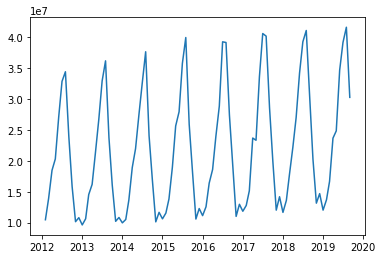

In [624]:
import matplotlib.pylab as plt
plt.plot(ts)

Now we check whether the time series is stationary or not. In order to build a model, we need a stationary time series. Thus, we define a function `test_stationary()`, which calculates the Rolling Statistics and the Dickey-Fuller tests. Both tests verify help us to verify the stationarity of the time series. I have taken this function from [this website](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000) and [this github](https://github.com/jacobstallone/Time_Series_ARIMA--Blog-and-code-/blob/master/Time%20Series.ipynb).

The `test_stationarity()` function requires the `statsmodels` libray. If you do not have it, you can install it, by typing into a cell the following command `!pip3 install statsmodels`.

In [625]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

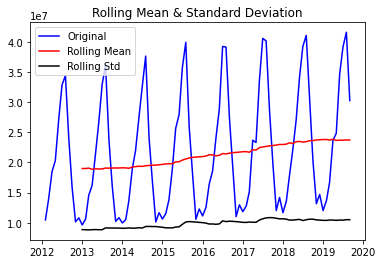

Results of Dickey-Fuller Test:
Test Statistic                 -0.075174
p-value                         0.951856
#Lags Used                     11.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
X is not stationary


In [626]:
test_stationarity(ts)

From the previous graph, it appears evident that the mean is not constant, thus there is an increasing trend in data, i.e. data are not stationary. In addition, the Dickey-Fuller tests needs that the Test statistics < critical values. In our case, the test statistic is greater than all the critical values, thus the series is clearly non stationary.

## Make the Time Series stationary
Many methods exist to transform a non stationary time series to a stationary one. The simplest method consists in building a new time series, which is the difference between an observation at time t and the observation at time t-1. This method is called Difference Transform. It can be used to remove the series dependence on time, so-called temporal dependence. Other methods are: logarithmic (`np.log(ts)`), square root (`np.sqrt(ts)`), cubic square root (`np.power(ts, 1/3)`) etc. Let's try the difference transformation.

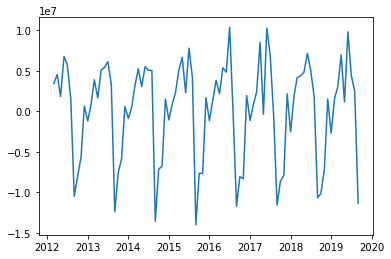

In [627]:
import numpy as np

ts_diff = ts.diff()
plt.plot(ts_diff)

The time series `ts_diff` contains the difference between `ts` at instant t and `ts` at instant t-1, thus, when t = 1 `ts_diff` does not contain any value. We remove these values.

In [628]:
ts_diff

date
2012-02-01           NaN
2012-03-01     3440108.0
2012-04-01     4547139.0
2012-05-01     1838165.0
2012-06-01     6807046.0
                 ...    
2019-05-01     1174262.0
2019-06-01     9825883.0
2019-07-01     4464216.0
2019-08-01     2465177.0
2019-09-01   -11334401.0
Name: value, Length: 92, dtype: float64

In [629]:
ts_diff.dropna(inplace=True)

Now we perform again the stationarity test.

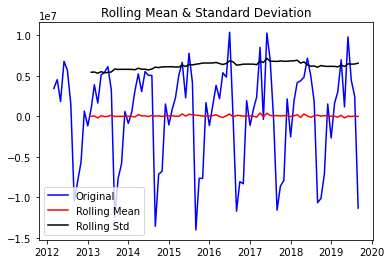

Results of Dickey-Fuller Test:
Test Statistic                -23.916031
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
X is stationary


In [630]:
test_stationarity(ts_diff)

According to the test, the time series is stationary, so we can use it for further analysis.

## Build the model
Before building the model, we decompose the time series in three parts: trend, seasonal and residual. `ts = trend + seasonal + residual`. We use the function `seasonal_decompose()`.

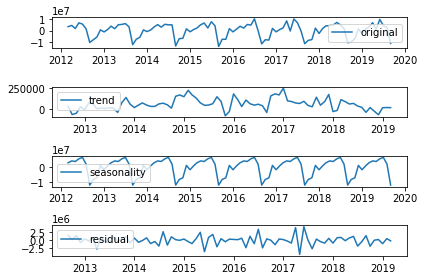

In [631]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_diff)

ts_trend = decomposition.trend
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_diff,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

Seasonal reveals that data have a seasonal behavior, so we can choose a model which takes into account seasonality. Before, choosing the model, we test the stationarity of residuals. In order to apply a model, they should be stationary.

In [632]:
ts_residual

date
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   NaN
2012-06-01   NaN
2012-07-01   NaN
              ..
2019-05-01   NaN
2019-06-01   NaN
2019-07-01   NaN
2019-08-01   NaN
2019-09-01   NaN
Name: resid, Length: 91, dtype: float64

We drop NaN values from `residual`.

In [633]:
ts_residual.dropna(inplace=True)

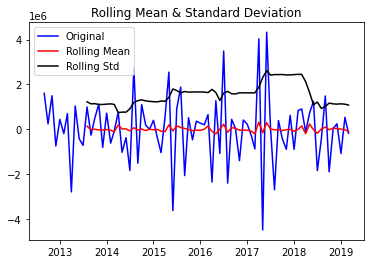

Results of Dickey-Fuller Test:
Test Statistic                 -5.192958
p-value                         0.000009
#Lags Used                     12.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64
X is stationary


In [634]:
test_stationarity(ts_residual)

### SARIMA Model
SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. It is composed of two models AR and MA. The model is defined by three parameters:
* p = order of the AR part
* d = degree of first differencing involved
* q = order of the moving average part.

The value of p can be determined through the ACF plot, which shows the autocorrelations which measure the relationship between an observation and its previous one.

The value of q can be determined through the PACF plot.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


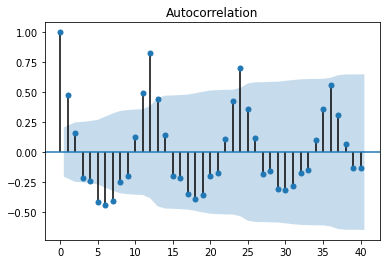

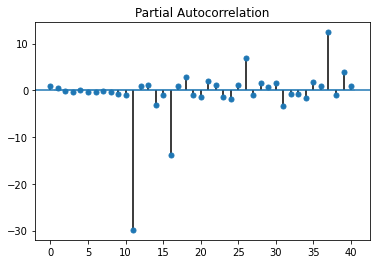

In [635]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_diff, lags =40)
plot_pacf(ts_diff, lags =40)

plt.show()

In the ACF plot the last large spike is  at lag 11. Thus, `p = 11`. PACF and `q = 0`, because there is not a specific behavior in PACF. You can give a look [here](https://machinelearningmastery.com/tune-arima-parameters-python/) for more details.

We split `ts_diff` in trainig and test set data. We use the first 2/3 of observations for training and the remaining for test.

In [641]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 12
q = 0
d = 1
X = ts_diff
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

model = SARIMAX(train, order=(p,d,q))
# nm
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   60
Model:              SARIMAX(12, 1, 0)   Log Likelihood                -929.772
Date:                Mon, 04 May 2020   AIC                           1885.545
Time:                        11:15:53   BIC                           1912.553
Sample:                    03-01-2012   HQIC                          1896.088
                         - 02-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4583      0.147     -9.937      0.000      -1.746      -1.171
ar.L2         -1.3889      0.164     -8.446      0.000      -1.711      -1.067
ar.L3         -1.4282      0.139    -10.295      0.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


We plot residuals 

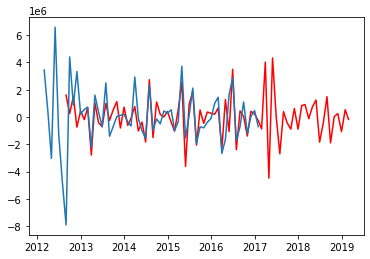

In [650]:
residuals = model_fit.resid
plt.plot(ts_residual, color='red')
plt.plot(residuals)

In order to evaluate the model, the distribution of residuals should be normal. We plot the graph of the residuals to the `distplot()` of the seaborn library. To install the seaborn library, please write in a cell: `!pip3 install seaborn` or `!pip install seaborn`.

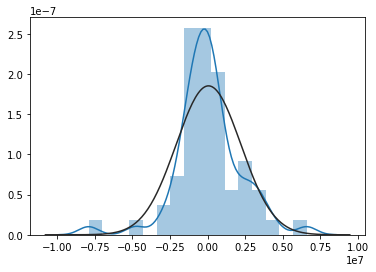

In [643]:
import seaborn as sns

sns.distplot(residuals ,fit = stats.norm) 

Graphically, it seams that residuals follow a normal distribution. However, we perform a normality test through the `normaltest()` function.

In [644]:
from scipy.stats import normaltest
statistic, pvalue = normaltest(residuals)
alpha = 1e-3
if pvalue < alpha :  
    print("X does not follow a normal distribution")
else:
    print("X follows a normal distribution")

X follows a normal distribution


Residual follow a normal distribution, thus we can use the model to predict future values. Firstly, we test the model on the test set.

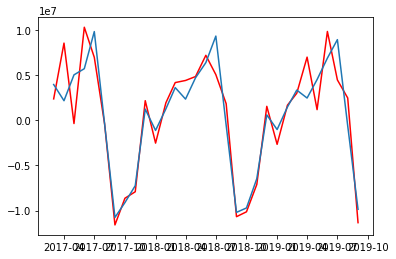

In [645]:
predictions = model_fit.forecast(steps=len(test))
plt.plot(test, color='red')
plt.plot(predictions)

Calculate the normalized root mean square error (NRMSE), which indicates a percentage. A low value indicates a small variance in residuals [Source Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [646]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
nrmse

0.11938511173713334

Predict values for the next two years.

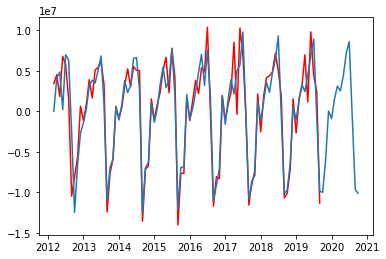

In [647]:
predictions = model_fit.predict(start=0, end=len(ts_diff)+12)
plt.plot(ts_diff, color='red')
plt.plot(predictions)

Restore original time series. Remind that we shift it to make it stationary. In order to restore the original time series we have to calculate the sum of values. We did two differences order (one in the SARIMAX model), thus we have to sum the second value of `ts` (given by `ts.iloc[1]`).

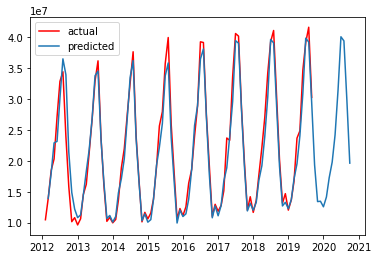

In [648]:
from datetime import datetime

complete_predictions = predictions.cumsum() + ts.iloc[1]
plt.plot(ts, color='red', label='actual')
plt.plot(complete_predictions, label='predicted')
plt.legend()
plt.show()


In [649]:
complete_predictions['2020-03-01']

17263911.830581993

## Bibliography
* [An example of time series](https://github.com/arshren/TimeSeries/blob/master/Stock%20Price%20APPL.ipynb)
* [ARIMA Model Python Example — Time Series Forecasting](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
* [ARIMA model to forecast international tourist visit
in Bumthang, Bhutan](https://iopscience.iop.org/article/10.1088/1742-6596/1039/1/012023/pdf)
* [Augmented Dickey-Fuller Test in Python](http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/)
* [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [How can I make a time-series stationary?](https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary)
* [How to Remove Trends and Seasonality with a Difference Transform in Python](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)
* [How to Tune ARIMA Parameters in Python](https://machinelearningmastery.com/tune-arima-parameters-python/)
* [Non-seasonal ARIMA models](https://otexts.com/fpp2/non-seasonal-arima.html)
* [Interpret the partial autocorrelation function (PACF)](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/)
* [Stationarity testing using the Augmented Dickey-Fuller test](https://medium.com/wwblog/stationarity-testing-using-the-augmented-dickey-fuller-test-8cf7f34f4844)
* [Time Series Forecast : A basic introduction using Python.](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)
* [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
* [Time Series Forecast Case Study with Python: Monthly Armed Robberies in Boston](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/)
* [Time Series prediction using SARIMAX](https://medium.com/datadriveninvestor/time-series-prediction-using-sarimax-a6604f258c56)
* [Understand ARIMA and tune P, D, Q](https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q)